#Downloads

In [ ]:
!pip install pytorch_lightning jiwer

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!wandb login 

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [ ]:
# install git-lfs first
!sudo apt-get install -y git-lfs
!git lfs install

# clone
!git clone https://huggingface.co/datasets/kylelovesllms/timit_asr_ipa

# rename folder
!mv timit_asr_ipa TIMIT

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Git LFS initialized.
Cloning into 'timit_asr_ipa'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (10/10), 2.96 KiB | 1010.00 KiB/s, done.
Filtering content: 100% (3/3), 445.65 MiB | 47.79 MiB/s, done.


In [ ]:
import os
import pandas as pd
import soundfile as sf  # or librosa

# Load parquet file
df = pd.read_parquet("/content/TIMIT/data/train-00000-of-00001.parquet")

for i, row in df.iterrows():
    audio_bytes = row["audio"]["bytes"]
    out_path = os.path.join("extracted", row["timit_path"])  # keep same folder layout
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    with open(out_path, "wb") as f:
        f.write(audio_bytes)

#DataLoader

In [ ]:
import json
from torch.utils.data import Dataset
import torch, librosa, gc
import ast
from transformers import Wav2Vec2FeatureExtractor
import numpy as np


feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=16000,
    padding_value=0.0,
    padding_side="right",
    do_normalize=False,           # let HF do z-score normalization
    return_attention_mask=True   # we will pass it to the model
)

with open('vocab.json') as f:
    dict_vocab = json.load(f)


def debug_stats(name, tensor, n_samples=8):
    # overall stats
    print(f"{name}:")
    print(f"  shape: {tuple(tensor.shape)}")
    print(f"  min:   {tensor.min().item():.4f}")
    print(f"  max:   {tensor.max().item():.4f}")
    print(f"  mean:  {tensor.float().mean().item():.4f}")
    print(f"  std:   {tensor.float().std().item():.4f}")

    # sample entries
    batch_size = tensor.shape[0] if tensor.ndim > 1 else 1
    n_to_show = min(n_samples, batch_size)

    for idx in range(n_to_show):
        if tensor.ndim > 1:
            arr = tensor[idx].detach().cpu()
        else:
            arr = tensor.detach().cpu()

        n = arr.shape[0]
        if n <= 15:
            sample = arr.tolist()
        else:
            first = arr[:5].tolist()
            mid   = arr[n//2 - 2 : n//2 + 3].tolist()
            last  = arr[-5:].tolist()
            sample = first + ["..."] + mid + ["..."] + last

        print(f"  sample[{idx}]: {sample}")

    print("-" * 50)




def normalize_for_wav(w):
    # ensure finite
    w = np.nan_to_num(w, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    if len(w) == 0:
        return np.zeros(160, dtype=np.float32)
    # scale by max abs so values are in [-1,1]
    m = np.max(np.abs(w))
    if m > 0:
        w = w / m
    return w

def text_to_tensor(string_text):
    text = string_text.split(" ")
    text_list = []
    for token in text:
        token = token.strip()
        if not token:
            continue
        if token not in dict_vocab:
            print("Unknown token:", token)
        else:
            text_list.append(dict_vocab[token])
    return text_list



In [ ]:

def collate_fn(batch):
    with torch.no_grad():
        waveforms, canonicals, transcripts, errors, outlens = [], [], [], [], []
        for w, c, t, e in batch:
            # w = normalize_for_wav(w)
            waveforms.append(w)
            canonicals.append(c)
            transcripts.append(t)
            errors.append(e)
            outlens.append(len(t))

        feats = feature_extractor(
            waveforms, sampling_rate=16000, return_tensors="pt", padding=True
        )


        canon_max = max(len(c) for c in canonicals) if canonicals else 0
        tran_max  = max(len(t) for t in transcripts) if transcripts else 0
        err_max   = max(len(e) for e in errors) if errors else 0

        canonicals  = [c + [70] * (canon_max - len(c)) for c in canonicals]
        transcripts = [t + [70] * (tran_max  - len(t)) for t in transcripts]
        errors      = [e + [2 ] * (err_max   - len(e)) for e in errors]

        canonicals  = torch.tensor(canonicals,  dtype=torch.long)
        transcripts = torch.tensor(transcripts, dtype=torch.long)
        errors      = torch.tensor(errors,      dtype=torch.long)
        outlens     = torch.tensor(outlens,     dtype=torch.long)


        # Debug prints______________________________________________________________________
        # debug_stats("input_values", feats.input_values)
        # debug_stats("attention_mask", feats.attention_mask)
        # debug_stats("canonicals", canonicals)
        # debug_stats("transcripts", transcripts)
        # debug_stats("errors", errors)
        # debug_stats("outlens", outlens)
        # print("waveform per-sample stds:", feats.input_values.std(dim=1))

        # # Alignment check
        # for i in range(len(batch)):
        #     x = feats.input_values[i]
        #     m = feats.attention_mask[i]

        #     # mask must be prefix of 1s then 0s
        #     m_np = m.detach().cpu().numpy()
        #     first_zero = (m_np == 0).argmax() if (m_np == 0).any() else len(m_np)
        #     cond_mask = np.all(m_np[:first_zero] == 1) and np.all(m_np[first_zero:] == 0)

        #     # padded region in x must be all 0
        #     cond_pad = torch.all(x[m == 0] == 0)

        #     aligned = bool(cond_mask and cond_pad)
        #     print(f"Sample {i} padding lined up? {aligned}")
        #_____________________________________________________________________________________

        return (
            feats.input_values,   # [B, T]
            feats.attention_mask, # [B, T]
            canonicals,
            transcripts,
            errors,
            outlens,
        )

In [ ]:
class L2_Dataset(Dataset):
    def __init__(self, data):
        self.len = len(data)
        self.path = data['Label']
        self.canonical = list(data['Canonical'])
        self.transcript = list(data['Transcript'])
        self.error = list(data['Error'])

    def __getitem__(self, idx):
        wav, _ = librosa.load(f"/content/extracted/{self.path[idx]}", sr=16000)
        canonical  = text_to_tensor(self.canonical[idx])
        transcript = text_to_tensor(self.transcript[idx])
        error      = ast.literal_eval(self.error[idx])
        return wav.astype(np.float32), canonical, transcript, error

    def __len__(self):
        return self.len

In [ ]:
import pandas as pd
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2PreTrainedModel, Wav2Vec2Model, Wav2Vec2Config
from torch.utils.data import DataLoader
import torch
import gc
import torch.nn as nn
from sklearn.model_selection import train_test_split


In [ ]:
# Load full dataset
df = pd.read_csv("/content/timit_arpabet_train.csv")
#df = df.head(300)


# Split 80/20 with shuffling
train_df, val_df = train_test_split(
    df,
    test_size=0.05,
    shuffle=False,
    random_state=42   # for reproducibility
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

In [ ]:
train_df

,Unnamed: 0,text,Label,Transcript,Canonical,Error
0,0,WOULD SUCH AN ACT OF REFUSAL BE USEFUL,TRAIN/DR4/MMDM0/SI681.wav,W UH D S AH CH AE N AE K T AH V R AH F Y UW Z ...,W UH D S AH CH AE N AE K T AH V R AH F Y UW Z ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,DON'T ASK ME TO CARRY AN OILY RAG LIKE THAT,TRAIN/DR4/MMDM0/SA2.wav,D OW N T AE S K M IY T UW K AE R IY AE N OY L ...,D OW N T AE S K M IY T UW K AE R IY AE N OY L ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2,BUTTERSCOTCH FUDGE GOES WELL WITH VANILLA ICE ...,TRAIN/DR4/MMDM0/SX411.wav,B AH T ER S K AA CH F AH JH G OW Z W EH L W IH...,B AH T ER S K AA CH F AH JH G OW Z W EH L W IH...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,3,SHE HAD YOUR DARK SUIT IN GREASY WASH WATER AL...,TRAIN/DR4/MMDM0/SA1.wav,SH IY HH AE D Y AO R D AA R K S UW T IH N G R ...,SH IY HH AE D Y AO R D AA R K S UW T IH N G R ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,4,I HONOR MY MOM,TRAIN/DR4/MMDM0/SX231.wav,AY AA N ER M AY M AA M,AY AA N ER M AY M AA M,"[1, 1, 1, 1, 1, 1, 1, 1, 1]"
...,...,...,...,...,...,...
3420,3420,A COMPLETE PLAN WE HAVE MADE LIMITED APPLICAT...,TRAIN/DR1/MGRL0/SI867.wav,AH K AH M P L IY T P L AE N W IY HH AE V M EY ...,AH K AH M P L IY T P L AE N W IY HH AE V M EY ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3421,3421,VALLEY LODGE YEARLY CELEBRATES THE FIRST CALF ...,TRAIN/DR1/MGRL0/SX417.wav,V AE L IY L AA JH Y IH R L IY S EH L AH B R EY...,V AE L IY L AA JH Y IH R L IY S EH L AH B R EY...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3422,3422,DON'T ASK ME TO CARRY AN OILY RAG LIKE THAT,TRAIN/DR1/MGRL0/SA2.wav,D OW N T AE S K M IY T UW K AE R IY AE N OY L ...,D OW N T AE S K M IY T UW K AE R IY AE N OY L ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3423,3423,SHE HAD YOUR DARK SUIT IN GREASY WASH WATER AL...,TRAIN/DR1/MGRL0/SA1.wav,SH IY HH AE D Y AO R D AA R K S UW T IH N G R ...,SH IY HH AE D Y AO R D AA R K S UW T IH N G R ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
import librosa
from tqdm import tqdm

audio_dir = "/content/extracted"

lengths = []
for label in tqdm(train_df["Label"]):
    wav_path = f"{audio_dir}/{label}"
    wav, _ = librosa.load(wav_path, sr=16000)
    duration = len(wav) / 16000.0   # seconds
    lengths.append(duration)

train_df["Audio Length"] = lengths


100%|██████████| 3425/3425 [00:01<00:00, 2797.76it/s]


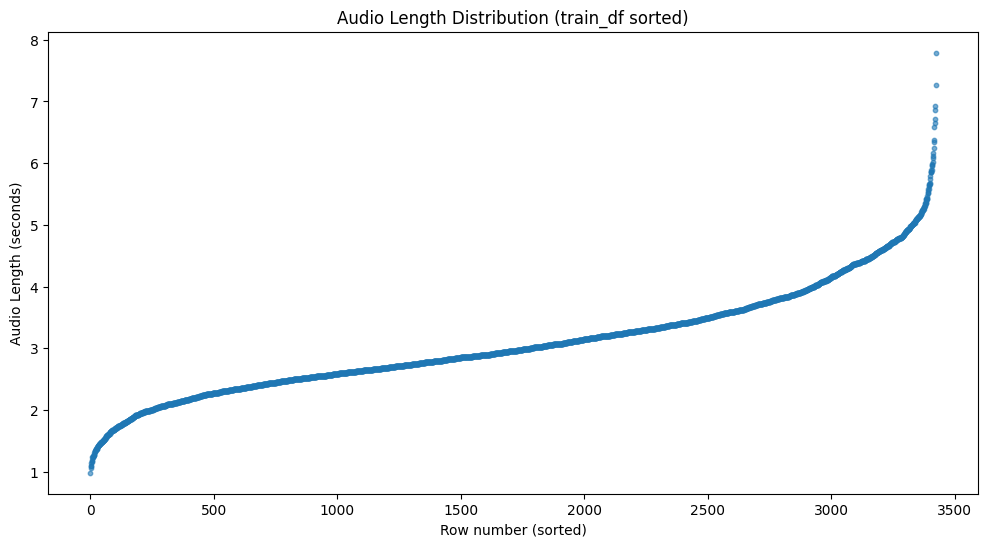

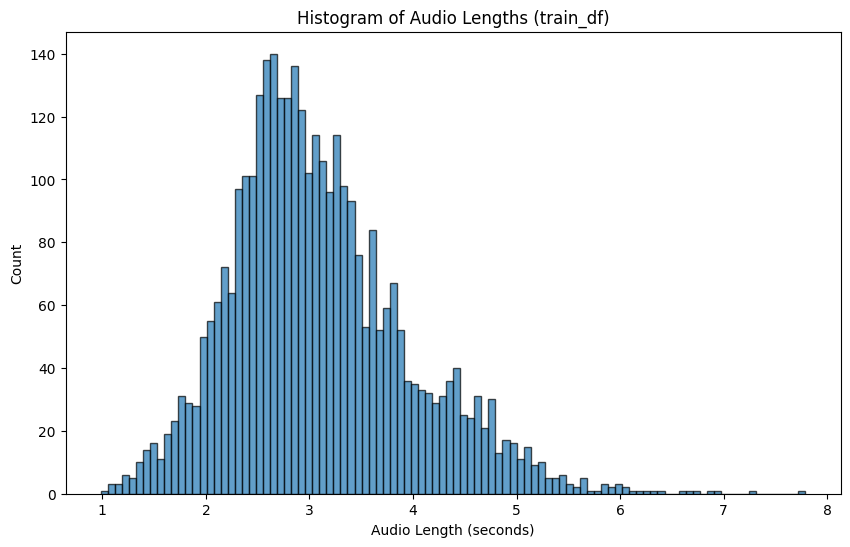

In [ ]:
import matplotlib.pyplot as plt

# Sort by Audio Length
train_df_sorted = train_df.sort_values(by="Audio Length").reset_index(drop=True)

# Scatter plot: row index vs audio length
plt.figure(figsize=(12, 6))
plt.scatter(train_df_sorted.index, train_df_sorted["Audio Length"], s=10, alpha=0.6)
plt.xlabel("Row number (sorted)")
plt.ylabel("Audio Length (seconds)")
plt.title("Audio Length Distribution (train_df sorted)")
plt.show()

# Histogram: audio length distribution
plt.figure(figsize=(10, 6))
plt.hist(train_df["Audio Length"], bins=100, edgecolor="black", alpha=0.7)
plt.xlabel("Audio Length (seconds)")
plt.ylabel("Count")
plt.title("Histogram of Audio Lengths (train_df)")
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def make_index_bins_divN(lengths, max_span=0.3, group=4):
    """
    lengths: 1D numpy array of audio lengths (unsorted)
    max_span: maximum allowed span for a bin (seconds)
    group: bin size must be divisible by this number (>= group)
    Returns: list of (start_idx, end_idx) pairs on the SORTED array, end_idx is exclusive.
    Ensures every non-final bin size is a multiple of `group` and >= `group`.
    """
    lengths_sorted = np.sort(lengths)
    n = len(lengths_sorted)
    bins_idx = []
    i = 0

    while i + group <= n:
        valid_sizes = []
        # try multiples of group
        for size in range(group, n - i + 1, group):
            span = lengths_sorted[i + size - 1] - lengths_sorted[i]
            if span <= max_span:
                remainder = n - (i + size)
                # accept only if remainder == 0 or remainder >= group
                if remainder == 0 or remainder >= group:
                    valid_sizes.append(size)
            else:
                break  # span too large, no need to try bigger

        if not valid_sizes:
            break  # cannot form a block here

        chosen = max(valid_sizes)
        bins_idx.append((i, i + chosen))
        i += chosen

    # final leftover
    if i < n:
        bins_idx.append((i, n))

    return bins_idx, lengths_sorted

# --- usage with group=4 ---
lengths = train_df["Audio Length"].values
bins_idx, lengths_sorted = make_index_bins_divN(lengths, max_span=0.21, group=8)

# Map sorted positions back to original row indices
sorted_order = np.argsort(lengths)
sorted_original_indices = train_df.index.values[sorted_order]

bin_id_for_sorted_pos = np.full(len(lengths), -1, dtype=int)
for b, (s, e) in enumerate(bins_idx):
    bin_id_for_sorted_pos[s:e] = b

bin_id_by_original_index = np.full(len(lengths), -1, dtype=int)
bin_id_by_original_index[sorted_original_indices] = bin_id_for_sorted_pos

train_df = train_df.copy()
train_df["Length Bin ID"] = bin_id_by_original_index

# Counts per bin
from collections import OrderedDict
counts_in_order = OrderedDict()
for b, (s, e) in enumerate(bins_idx):
    counts_in_order[f"bin_{b} ({lengths_sorted[s]:.3f},{lengths_sorted[e-1]:.3f})"] = (e - s)

# HARD CHECK: every non-final bin must be divisible by group
for b, (s, e) in enumerate(bins_idx):
    size = e - s
    if b < len(bins_idx) - 1:
        assert size % 4 == 0 and size >= 4, f"Bin {b} size {size} not multiple of 4"

print("Counts per bin (in bin order, start..end length shown):")
for k, v in counts_in_order.items():
    print(f"{k}\t{v}")

# Human labels
bin_labels = []
for b, (s, e) in enumerate(bins_idx):
    label = f"[{lengths_sorted[s]:.3f}, {lengths_sorted[e-1]:.3f}]"
    bin_labels.append(label)

label_map = {b: bin_labels[b] for b in range(len(bin_labels))}
train_df["Length Bin Label"] = train_df["Length Bin ID"].map(label_map)

print("\nBin labels (in order):")
for i, lbl in enumerate(bin_labels):
    print(i, lbl)


Counts per bin (in bin order, start..end length shown):
bin_0 (0.986,1.190)	8
bin_1 (1.235,1.421)	24
bin_2 (1.421,1.600)	40
bin_3 (1.600,1.805)	72
bin_4 (1.805,2.003)	104
bin_5 (2.003,2.208)	184
bin_6 (2.208,2.413)	264
bin_7 (2.413,2.618)	368
bin_8 (2.618,2.822)	392
bin_9 (2.822,3.027)	368
bin_10 (3.027,3.232)	320
bin_11 (3.232,3.437)	304
bin_12 (3.437,3.642)	208
bin_13 (3.648,3.846)	176
bin_14 (3.846,4.045)	120
bin_15 (4.051,4.237)	88
bin_16 (4.243,4.442)	104
bin_17 (4.442,4.640)	80
bin_18 (4.646,4.851)	72
bin_19 (4.858,5.030)	40
bin_20 (5.030,5.229)	32
bin_21 (5.229,5.357)	16
bin_22 (5.382,5.517)	8
bin_23 (5.523,5.670)	8
bin_24 (5.677,7.789)	25

Bin labels (in order):
0 [0.986, 1.190]
1 [1.235, 1.421]
2 [1.421, 1.600]
3 [1.600, 1.805]
4 [1.805, 2.003]
5 [2.003, 2.208]
6 [2.208, 2.413]
7 [2.413, 2.618]
8 [2.618, 2.822]
9 [2.822, 3.027]
10 [3.027, 3.232]
11 [3.232, 3.437]
12 [3.437, 3.642]
13 [3.648, 3.846]
14 [3.846, 4.045]
15 [4.051, 4.237]
16 [4.243, 4.442]
17 [4.442, 4.640]
18 [4.6

In [ ]:
train_df

,Unnamed: 0,text,Label,Transcript,Canonical,Error,Audio Length,Length Bin ID,Length Bin Label
0,0,WOULD SUCH AN ACT OF REFUSAL BE USEFUL,TRAIN/DR4/MMDM0/SI681.wav,W UH D S AH CH AE N AE K T AH V R AH F Y UW Z ...,W UH D S AH CH AE N AE K T AH V R AH F Y UW Z ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.496000,7,"[2.413, 2.618]"
1,1,DON'T ASK ME TO CARRY AN OILY RAG LIKE THAT,TRAIN/DR4/MMDM0/SA2.wav,D OW N T AE S K M IY T UW K AE R IY AE N OY L ...,D OW N T AE S K M IY T UW K AE R IY AE N OY L ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.528000,7,"[2.413, 2.618]"
2,2,BUTTERSCOTCH FUDGE GOES WELL WITH VANILLA ICE ...,TRAIN/DR4/MMDM0/SX411.wav,B AH T ER S K AA CH F AH JH G OW Z W EH L W IH...,B AH T ER S K AA CH F AH JH G OW Z W EH L W IH...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3.507250,12,"[3.437, 3.642]"
3,3,SHE HAD YOUR DARK SUIT IN GREASY WASH WATER AL...,TRAIN/DR4/MMDM0/SA1.wav,SH IY HH AE D Y AO R D AA R K S UW T IH N G R ...,SH IY HH AE D Y AO R D AA R K S UW T IH N G R ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3.161625,10,"[3.027, 3.232]"
4,4,I HONOR MY MOM,TRAIN/DR4/MMDM0/SX231.wav,AY AA N ER M AY M AA M,AY AA N ER M AY M AA M,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",1.619250,3,"[1.600, 1.805]"
...,...,...,...,...,...,...,...,...,...
3420,3420,A COMPLETE PLAN WE HAVE MADE LIMITED APPLICAT...,TRAIN/DR1/MGRL0/SI867.wav,AH K AH M P L IY T P L AE N W IY HH AE V M EY ...,AH K AH M P L IY T P L AE N W IY HH AE V M EY ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3.852813,14,"[3.846, 4.045]"
3421,3421,VALLEY LODGE YEARLY CELEBRATES THE FIRST CALF ...,TRAIN/DR1/MGRL0/SX417.wav,V AE L IY L AA JH Y IH R L IY S EH L AH B R EY...,V AE L IY L AA JH Y IH R L IY S EH L AH B R EY...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.963250,9,"[2.822, 3.027]"
3422,3422,DON'T ASK ME TO CARRY AN OILY RAG LIKE THAT,TRAIN/DR1/MGRL0/SA2.wav,D OW N T AE S K M IY T UW K AE R IY AE N OY L ...,D OW N T AE S K M IY T UW K AE R IY AE N OY L ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.860813,9,"[2.822, 3.027]"
3423,3423,SHE HAD YOUR DARK SUIT IN GREASY WASH WATER AL...,TRAIN/DR1/MGRL0/SA1.wav,SH IY HH AE D Y AO R D AA R K S UW T IH N G R ...,SH IY HH AE D Y AO R D AA R K S UW T IH N G R ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.560000,7,"[2.413, 2.618]"


In [ ]:
import numpy as np
import pandas as pd

def shuffle_bins_keep_last(df):
    df = df.copy()

    # Step 1: sort by audio length
    df = df.sort_values("Audio Length").reset_index(drop=True)

    # Step 2: shuffle within each bin
    bins = []
    for b_id, group in df.groupby("Length Bin ID", sort=False):
        group_shuffled = group.sample(frac=1, random_state=None).reset_index(drop=True)
        bins.append((b_id, group_shuffled))

    # Step 3: separate last bin
    bins_sorted = sorted(bins, key=lambda x: x[0])  # ensure bin order
    bins_to_shuffle = bins_sorted[:-1]              # all but last
    last_bin = bins_sorted[-1]                      # last one

    # Shuffle the other bins
    rng = np.random.default_rng()
    rng.shuffle(bins_to_shuffle)

    # Step 4: concatenate shuffled bins + last bin
    final_bins = bins_to_shuffle + [last_bin]
    shuffled_df = pd.concat([g for _, g in final_bins], ignore_index=True)

    return shuffled_df

# Usage
shuffled_train_df = shuffle_bins_keep_last(train_df)

In [ ]:
import random

# get unique bin IDs from the dataframe
bin_ids = shuffled_train_df["Length Bin ID"].unique().tolist()

# exclude last bin if needed
bin_ids_except_last = bin_ids[:-1]
random.shuffle(bin_ids_except_last)

bin_ids_shuffled = bin_ids_except_last + [bin_ids[-1]]

# print counts in shuffled order
print("Counts per bin in shuffled order:")
for b_id in bin_ids_shuffled:
    count = (shuffled_train_df["Length Bin ID"] == b_id).sum()
    label = shuffled_train_df.loc[
        shuffled_train_df["Length Bin ID"] == b_id, "Length Bin Label"
    ].iloc[0]
    print(f"Bin {label}: {count}")


Counts per bin in shuffled order:
Bin [0.986, 1.190]: 8
Bin [2.413, 2.618]: 368
Bin [5.030, 5.229]: 32
Bin [3.027, 3.232]: 320
Bin [5.229, 5.357]: 16
Bin [2.618, 2.822]: 392
Bin [4.243, 4.442]: 104
Bin [4.051, 4.237]: 88
Bin [1.235, 1.421]: 24
Bin [5.382, 5.517]: 8
Bin [1.600, 1.805]: 72
Bin [5.523, 5.670]: 8
Bin [4.442, 4.640]: 80
Bin [2.003, 2.208]: 184
Bin [1.421, 1.600]: 40
Bin [2.822, 3.027]: 368
Bin [2.208, 2.413]: 264
Bin [4.646, 4.851]: 72
Bin [1.805, 2.003]: 104
Bin [3.437, 3.642]: 208
Bin [3.648, 3.846]: 176
Bin [3.232, 3.437]: 304
Bin [4.858, 5.030]: 40
Bin [3.846, 4.045]: 120
Bin [5.677, 7.789]: 25


In [ ]:
shuffled_train_df

,Unnamed: 0,text,Label,Transcript,Canonical,Error,Audio Length,Length Bin ID,Length Bin Label
0,1877,DON'T ASK ME TO CARRY AN OILY RAG LIKE THAT,TRAIN/DR2/FDXW0/SA2.wav,D OW N T AE S K M IY T UW K AE R IY AE N OY L ...,D OW N T AE S K M IY T UW K AE R IY AE N OY L ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.508812,7,"[2.413, 2.618]"
1,2214,ROUGH CLOTH RASPED HIS FIST,TRAIN/DR5/FPMY0/SI1783.wav,R AH F K L AO TH R AE S P T HH IH Z F IH S T,R AH F K L AO TH R AE S P T HH IH Z F IH S T,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.521625,7,"[2.413, 2.618]"
2,1803,TOP ZINNIAS RARELY HAVE CROOKED STEMS,TRAIN/DR2/MKAJ0/SX424.wav,T AA P Z IH N IY AH Z R EH R L IY HH AE V K R ...,T AA P Z IH N IY AH Z R EH R L IY HH AE V K R ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.470438,7,"[2.413, 2.618]"
3,370,DON'T ASK ME TO CARRY AN OILY RAG LIKE THAT,TRAIN/DR4/MJJJ0/SA2.wav,D OW N T AE S K M IY T UW K AE R IY AE N OY L ...,D OW N T AE S K M IY T UW K AE R IY AE N OY L ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.604812,7,"[2.413, 2.618]"
4,1368,HELP CELEBRATE YOUR BROTHER'S SUCCESS,TRAIN/DR3/FDJH0/SX35.wav,HH EH L P S EH L AH B R EY T Y AO R B R AH DH ...,HH EH L P S EH L AH B R EY T Y AO R B R AH DH ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.521625,7,"[2.413, 2.618]"
...,...,...,...,...,...,...,...,...,...
3420,374,NO MORE STARTLING CONTRAST TO A SYSTEM OF SULL...,TRAIN/DR4/MJJJ0/SI1163.wav,N OW M AO R S T AA R T L IH NG K AA N T R AE S...,N OW M AO R S T AA R T L IH NG K AA N T R AE S...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5.888000,24,"[5.677, 7.789]"
3421,3273,SHELL SHOCK CAUSED BY SHRAPNEL IS SOMETIMES CU...,TRAIN/DR1/FKFB0/SX438.wav,SH EH L SH AA K K AA Z D B AY SH R AE P N AH L...,SH EH L SH AA K K AA Z D B AY SH R AE P N AH L...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",6.380813,24,"[5.677, 7.789]"
3422,2616,AT THE LEFT IS A PAIR OF DRESSY STRAW PUMPS IN...,TRAIN/DR5/FDMY0/SI567.wav,AE T DH AH L EH F T IH Z AH P EH R AH V D R EH...,AE T DH AH L EH F T IH Z AH P EH R AH V D R EH...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",6.342437,24,"[5.677, 7.789]"
3423,2493,DID YOU KNOW HE IS ADVERTISING HIS HAM RADIO E...,TRAIN/DR5/MMWB0/SI2249.wav,D IH D Y UW N OW HH IY IH Z AE D V ER T AY Z I...,D IH D Y UW N OW HH IY IH Z AE D V ER T AY Z I...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5.888000,24,"[5.677, 7.789]"


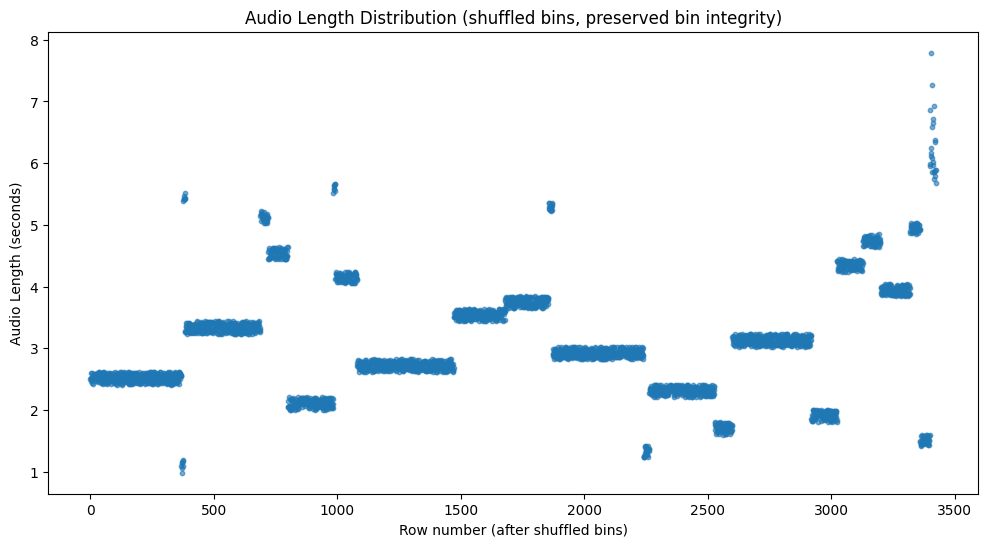

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot of shuffled dataframe
plt.figure(figsize=(12, 6))
plt.scatter(shuffled_train_df.index, shuffled_train_df["Audio Length"], s=10, alpha=0.6)

plt.xlabel("Row number (after shuffled bins)")
plt.ylabel("Audio Length (seconds)")
plt.title("Audio Length Distribution (shuffled bins, preserved bin integrity)")
plt.show()



In [ ]:
train_df = shuffled_train_df.copy()

In [ ]:
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)


train_dataset = L2_Dataset(train_df )
val_dataset   = L2_Dataset(val_df)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,   # usually no shuffle for validation
    collate_fn=collate_fn
)

In [ ]:
batch = next(iter(train_loader))

In [ ]:
from collections import Counter

def count_word_freq(df, column="Transcript"):
    counter = Counter()
    for text in df[column]:
        tokens = text.split()
        counter.update(tokens)
    return counter

# Count frequencies in train + val
train_counts = count_word_freq(train_df, "Transcript")
val_counts   = count_word_freq(val_df, "Transcript")

# Merge if you want overall
all_counts = train_counts + val_counts

# Show top 20 most common words
print("Top 28 transcript tokens:")
for word, freq in all_counts.most_common(28):
    print(f"{word:15s} {freq}")


Top 28 transcript tokens:
AH              9112
T               8008
N               7084
R               6610
IH              6397
S               5923
IY              5692
L               5406
K               5012
D               4994
AE              4438
Z               3234
M               3180
ER              2974
AA              2843
UW              2662
AO              2642
W               2496
DH              2490
EH              2420
P               2312
AY              1952
B               1877
G               1852
HH              1736
OW              1702
F               1696
SH              1681


#Model

In [ ]:
from transformers import Wav2Vec2Config, Wav2Vec2Model
import torch
import torch.nn.functional as F
import torch.nn as nn
from functools import reduce
import operator


In [ ]:
class RLIUCTC(nn.Module):
    def __init__(self, wav2vec2_name=None):
        super().__init__()

        # load config & model
        config        = Wav2Vec2Config.from_pretrained(wav2vec2_name)
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(wav2vec2_name, config=config)

        # finetuning head
        #self.canonical_embedding = nn.Embedding(70, 768, 69)
        self.classifier          = nn.Linear(1024, 70)

    def freeze_feature_extractor(self):
        for param in self.wav2vec2.feature_extractor.parameters():
            param.requires_grad = False


    def forward(self, waveform, attention_mask=None):
        """
        waveform: [B, L] raw audio
        attention_mask: [B, L] with 1=real, 0=pad
        """
        # pass through Wav2Vec2
        wavvec_out = self.wav2vec2(
            waveform,
            attention_mask=attention_mask,
            return_dict=True
        ).last_hidden_state   # [B, T1, 768]
        #print("After wav2vec:", wavvec_out)
        #debug_wavvec_out(wavvec_out, n_batch_samples=8, n_feat_show=5)
        B, T1, C = wavvec_out.shape

        # classifier
        logits = self.classifier(wavvec_out)  # [B, T1, vocab]

        # compute frame-level lengths (scale raw mask length into T1 units)
        if attention_mask is not None:
            raw_lengths = attention_mask.sum(dim=1)             # [B], number of real audio samples
            input_lengths = torch.floor(raw_lengths.float() * T1 / attention_mask.shape[1]).long()
        else:
            input_lengths = torch.full((B,), T1, dtype=torch.long, device=wavvec_out.device)

        # print("logits:", logits.shape)
        # print("input_lengths:", input_lengths)

        return logits, input_lengths

In [ ]:
import pytorch_lightning as pl
from jiwer import wer

In [ ]:
class Lightning(pl.LightningModule):
    def __init__(self, lr=1e-5, l1w=0.5, l2w=0.5,wav2vec2_type="facebook/wav2vec2-base-100h"):
        super().__init__()

        self.model = RLIUCTC(wav2vec2_name=wav2vec2_type)

        for param in self.model.wav2vec2.feature_extractor.parameters():
            param.requires_grad = False
        self.model.wav2vec2.feature_extractor.eval()

        self.ctc_loss = nn.CTCLoss(blank=69)
        self.lr = lr

    def forward(self, waveform, attention_mask):
        return self.model(waveform, attention_mask)

    def training_step(self, train_batch, batch_idx):
        waveform, attention_mask, _, transcript, _, _ = train_batch

        logits, input_lengths = self(waveform, attention_mask)
        log_probs = F.log_softmax(logits, dim=-1).transpose(0, 1)  # [T1, B, V]

        # probability mass in blank token (id=69)
        blank_mass = torch.exp(log_probs[..., 69]).mean().item()

        # targets and lengths
        target_lengths = (transcript != 70).sum(dim=1).long()  # [B]
        targets = transcript[transcript != 70]                 # flatten

        # ------------------- DEBUG CHECKS -------------------
        if self.global_step % 20 == 0:
            B, T1, V = logits.shape
            print(f"Step {self.global_step} | Avg blank prob: {blank_mass:.4f}")
            print("T1 (frames):", T1)
            print("Target lens:", target_lengths.tolist())
            print("Input lens:", input_lengths.tolist())

            # inspect probability distribution for the first sample (mid-frame)
            probs = torch.softmax(logits[0], dim=-1)  # [T1, V]
            mid_t = probs.shape[0] // 2
            topk = torch.topk(probs[mid_t], 5, dim=-1)
            print("Top5 probs at frame", mid_t, ":",
                  topk.indices.tolist(), topk.values.tolist())
        # -----------------------------------------------------

        loss = self.ctc_loss(log_probs, targets, input_lengths, target_lengths)
        if self.global_step % 20 == 0:
          print("Current CTC loss: ",loss)
          print("-" * 80)

        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss


    def validation_step(self, batch, batch_idx):
        waveform, attention_mask, _, transcript, _, _ = batch
        logits, input_lengths = self(waveform, attention_mask)
        log_probs = F.log_softmax(logits, dim=-1).transpose(0, 1)  # [T, B, V]

        # targets and lengths
        target_lengths = (transcript != 70).sum(dim=1).long()
        targets = transcript[transcript != 70]

        loss = self.ctc_loss(log_probs, targets, input_lengths, target_lengths)

        # greedy decoding: argmax over vocab dim
        pred_ids = log_probs.argmax(dim=-1).transpose(0, 1)  # [B, T]
        collapsed_preds = []
        for seq in pred_ids:
            collapsed = []
            prev = None
            for token in seq.tolist():
                if token != prev and token != 69:  # skip repeats and blanks
                    collapsed.append(token)
                prev = token
            collapsed_preds.append(collapsed)

        # collapse transcript (remove pads/blanks)
        target_seqs = []
        for t in transcript:
            target_seqs.append([tok.item() for tok in t if tok.item() != 69])

        # print first example for inspection
        print("Prediction[0]:", collapsed_preds[0])
        print("Target[0]:    ", target_seqs[0])

        # ---- WER calculation ----
        pred_strs   = [" ".join(map(str, p)) for p in collapsed_preds]
        target_strs = [" ".join(map(str, t)) for t in target_seqs]

        total_wer = 0.0
        for pred, tgt in zip(pred_strs, target_strs):
            total_wer += wer(tgt, pred)
        avg_wer = total_wer / len(pred_strs)

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_wer", avg_wer, prog_bar=True, on_step=False, on_epoch=True)

        return loss


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW([
              {"params": self.model.wav2vec2.parameters(), "lr": self.lr},
              {"params": self.model.classifier.parameters(), "lr": 1e-3},
          ])
        return optimizer





In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
from google.colab import userdata
from huggingface_hub import login
from datasets import load_dataset


try:
    hf_token = userdata.get('pronunciation_test')
except userdata.SecretNotFoundError:
    print("Secret 'pronunciation' not found.")
    exit()

# 2. Đăng nhập vào Hugging Face Hub
# Code sẽ dùng token bạn cung cấp để xác thực
login(token=hf_token)

In [ ]:

# WandB setup
wandb_logger = WandbLogger(
    project="TestRLIU1",
    entity="vuihoc",
    name="bucket-batching-test-2"
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",     # <-- match Lightning log key
    mode="min",
    save_top_k=1,
    filename="best-checkpoint"
)

# Trainer
trainer = pl.Trainer(
    precision=32,
    max_epochs=5,
    accelerator="gpu", devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
    log_every_n_steps=10
)

model = Lightning(
    lr=3e-5,
    l1w=0.5,
    l2w=0.5,
    wav2vec2_type="KoelLabs/xlsr-english-01"
)

import gc
gc.collect()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


418

In [148]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type    | Params | Mode 
---------------------------------------------
0 | model    | RLIUCTC | 315 M  | train
1 | ctc_loss | CTCLoss | 0      | train
---------------------------------------------
311 M     Trainable params
4.2 M     Non-trainable params
315 M     Total params
1,262.042 Total estimated model params size (MB)
3         Modules in train mode
406       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Prediction[0]: [7, 32, 7, 56, 59, 25, 32, 25, 34, 25, 58, 32, 26, 67, 32, 34, 44, 34, 56, 44, 34, 44, 64, 34, 23, 34, 44, 22, 44, 56, 58, 44, 7, 56, 3, 32, 7, 44, 7]
Target[0]:     [17, 4, 35, 21, 32, 21, 61, 0, 65, 4, 15, 61, 6, 48, 26]
Prediction[0]: [7, 44, 40, 7, 68, 32, 50, 54, 34, 44, 54, 34, 44, 34, 58, 32, 44, 50, 25, 44, 10, 44, 56, 8, 26, 32, 1, 38, 34, 44, 25, 44, 56, 34, 32, 50, 40, 14, 23, 48, 44, 10, 44, 56, 67, 56, 67, 34, 26, 64, 44, 32, 26, 32]
Target[0]:     [17, 4, 46, 48, 8, 37, 21, 61, 6, 48, 4, 50, 35, 32, 39, 2, 50, 35, 26, 6, 48, 15, 31, 50, 27, 11, 65]


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:527: Found 406 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

Step 0 | Avg blank prob: 0.0158
T1 (frames): 129
Target lens: [29, 19, 28, 29, 27, 21, 23, 29]
Input lens: [124, 124, 122, 129, 124, 128, 123, 122]
Top5 probs at frame 64 : [26, 56, 51, 34, 8] [0.021020131185650826, 0.019078662618994713, 0.019045617431402206, 0.0186567772179842, 0.018432412296533585]
Current CTC loss:  tensor(17.2090, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------------------------------------------
Step 20 | Avg blank prob: 0.9232
T1 (frames): 129
Target lens: [29, 19, 29, 26, 35, 29, 29, 28]
Input lens: [124, 129, 128, 120, 122, 121, 120, 124]
Top5 probs at frame 64 : [69, 2, 52, 37, 32] [0.966460108757019, 0.0032642518635839224, 0.002637348836287856, 0.0024380723480135202, 0.0020908797159790993]
Current CTC loss:  tensor(3.9109, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------------------------------------------
Step 40 | Avg blank prob: 0.7698
T1 (frames): 130
Target lens: [31, 28, 30, 25

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction[0]: [35, 21, 48, 32, 4, 61, 0, 65, 4, 15, 61, 6, 48, 26]
Target[0]:     [17, 4, 35, 21, 32, 21, 61, 0, 65, 4, 15, 61, 6, 48, 26]
Prediction[0]: [46, 48, 8, 37, 21, 61, 6, 4, 50, 35, 32, 39, 19, 50, 26, 6, 48, 15, 31, 50, 27, 11, 65]
Target[0]:     [17, 4, 46, 48, 8, 37, 21, 61, 6, 48, 4, 50, 35, 32, 39, 2, 50, 35, 26, 6, 48, 15, 31, 50, 27, 11, 65]
Prediction[0]: [17, 4, 27, 4, 52, 21, 43, 37, 2, 42, 27, 61, 31, 33, 26, 48, 4, 39, 17, 4, 27, 19, 52, 43, 50, 52, 0, 46, 52]
Target[0]:     [17, 4, 27, 4, 52, 21, 4, 37, 37, 2, 42, 27, 61, 4, 33, 26, 48, 4, 39, 17, 4, 27, 19, 52, 43, 50, 52, 0, 46, 52]
Prediction[0]: [2, 37, 48, 32, 50, 32, 59, 15, 4, 33, 45, 40, 52, 4, 46, 45, 40, 52, 39, 4, 40, 52, 31, 40, 17, 4, 12, 11, 0, 37, 4, 33, 32, 4, 40, 15, 17, 4, 19, 40, 33, 4, 40, 31, 48, 31, 42, 15, 31, 46, 0, 48, 52, 39, 4, 40, 52, 50]
Target[0]:     [2, 37, 48, 4, 50, 32, 59, 15, 4, 33, 45, 40, 52, 4, 46, 45, 40, 52, 39, 4, 40, 52, 31, 40, 17, 4, 12, 11, 0, 37, 4, 33, 32, 4, 40, 1

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction[0]: [35, 19, 48, 32, 4, 61, 0, 65, 4, 15, 61, 6, 48, 26]
Target[0]:     [17, 4, 35, 21, 32, 21, 61, 0, 65, 4, 15, 61, 6, 48, 26]
Prediction[0]: [46, 8, 37, 21, 61, 6, 48, 4, 50, 35, 32, 39, 2, 50, 35, 26, 6, 48, 15, 31, 50, 27, 11, 65]
Target[0]:     [17, 4, 46, 48, 8, 37, 21, 61, 6, 48, 4, 50, 35, 32, 39, 2, 50, 35, 26, 6, 48, 15, 31, 50, 27, 11, 65]
Prediction[0]: [17, 4, 27, 4, 52, 21, 4, 37, 37, 2, 42, 27, 61, 31, 33, 26, 48, 4, 39, 17, 4, 27, 4, 52, 43, 50, 52, 0, 46, 52]
Target[0]:     [17, 4, 27, 4, 52, 21, 4, 37, 37, 2, 42, 27, 61, 4, 33, 26, 48, 4, 39, 17, 4, 27, 19, 52, 43, 50, 52, 0, 46, 52]
Prediction[0]: [19, 37, 48, 32, 50, 32, 59, 15, 4, 33, 45, 40, 52, 4, 46, 45, 40, 52, 39, 4, 40, 52, 31, 40, 17, 4, 12, 11, 0, 37, 4, 33, 32, 4, 40, 15, 17, 4, 19, 40, 33, 4, 40, 31, 48, 31, 42, 15, 31, 46, 0, 48, 52, 39, 4, 40, 52, 50]
Target[0]:     [2, 37, 48, 4, 50, 32, 59, 15, 4, 33, 45, 40, 52, 4, 46, 45, 40, 52, 39, 4, 40, 52, 31, 40, 17, 4, 12, 11, 0, 37, 4, 33, 32, 4,

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction[0]: [35, 2, 48, 32, 4, 61, 0, 65, 4, 15, 4, 61, 6, 26]
Target[0]:     [17, 4, 35, 21, 32, 21, 61, 0, 65, 4, 15, 61, 6, 48, 26]
Prediction[0]: [46, 48, 8, 37, 43, 61, 6, 48, 4, 50, 35, 32, 39, 2, 50, 35, 26, 6, 48, 15, 31, 50, 27, 11, 65]
Target[0]:     [17, 4, 46, 48, 8, 37, 21, 61, 6, 48, 4, 50, 35, 32, 39, 2, 50, 35, 26, 6, 48, 15, 31, 50, 27, 11, 65]
Prediction[0]: [17, 4, 27, 4, 52, 21, 43, 37, 2, 42, 27, 61, 4, 33, 26, 48, 4, 39, 17, 4, 27, 4, 52, 43, 50, 52, 0, 46, 52]
Target[0]:     [17, 4, 27, 4, 52, 21, 4, 37, 37, 2, 42, 27, 61, 4, 33, 26, 48, 4, 39, 17, 4, 27, 19, 52, 43, 50, 52, 0, 46, 52]
Prediction[0]: [19, 37, 48, 32, 50, 32, 59, 15, 4, 33, 45, 40, 52, 4, 46, 45, 40, 52, 39, 4, 40, 52, 31, 40, 17, 4, 12, 11, 0, 37, 4, 33, 32, 4, 40, 15, 17, 4, 19, 40, 33, 4, 40, 31, 48, 31, 42, 15, 31, 46, 0, 48, 52, 39, 4, 40, 52, 50]
Target[0]:     [2, 37, 48, 4, 50, 32, 59, 15, 4, 33, 45, 40, 52, 4, 46, 45, 40, 52, 39, 4, 40, 52, 31, 40, 17, 4, 12, 11, 0, 37, 4, 33, 32, 4, 4

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction[0]: [35, 2, 48, 32, 4, 61, 0, 65, 4, 15, 61, 6, 48, 26]
Target[0]:     [17, 4, 35, 21, 32, 21, 61, 0, 65, 4, 15, 61, 6, 48, 26]
Prediction[0]: [46, 48, 8, 37, 43, 61, 6, 48, 4, 50, 35, 32, 39, 2, 50, 26, 6, 48, 15, 31, 50, 27, 11, 65]
Target[0]:     [17, 4, 46, 48, 8, 37, 21, 61, 6, 48, 4, 50, 35, 32, 39, 2, 50, 35, 26, 6, 48, 15, 31, 50, 27, 11, 65]
Prediction[0]: [17, 4, 27, 4, 52, 21, 43, 37, 37, 2, 42, 27, 61, 4, 33, 26, 48, 4, 39, 17, 4, 27, 4, 52, 43, 50, 52, 0, 46, 52]
Target[0]:     [17, 4, 27, 4, 52, 21, 4, 37, 37, 2, 42, 27, 61, 4, 33, 26, 48, 4, 39, 17, 4, 27, 19, 52, 43, 50, 52, 0, 46, 52]
Prediction[0]: [19, 37, 48, 4, 50, 32, 59, 15, 4, 33, 45, 40, 52, 4, 46, 45, 40, 52, 39, 4, 40, 52, 31, 40, 17, 4, 12, 11, 0, 37, 4, 33, 32, 4, 40, 15, 17, 4, 19, 40, 33, 4, 40, 31, 48, 31, 42, 15, 31, 46, 0, 48, 52, 39, 4, 40, 52, 50]
Target[0]:     [2, 37, 48, 4, 50, 32, 59, 15, 4, 33, 45, 40, 52, 4, 46, 45, 40, 52, 39, 4, 40, 52, 31, 40, 17, 4, 12, 11, 0, 37, 4, 33, 32, 4, 4

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction[0]: [35, 2, 48, 32, 4, 61, 0, 65, 4, 15, 61, 6, 48, 26]
Target[0]:     [17, 4, 35, 21, 32, 21, 61, 0, 65, 4, 15, 61, 6, 48, 26]
Prediction[0]: [46, 48, 8, 37, 21, 61, 6, 48, 4, 50, 35, 32, 39, 2, 50, 35, 26, 6, 48, 15, 31, 50, 27, 11, 65]
Target[0]:     [17, 4, 46, 48, 8, 37, 21, 61, 6, 48, 4, 50, 35, 32, 39, 2, 50, 35, 26, 6, 48, 15, 31, 50, 27, 11, 65]
Prediction[0]: [17, 4, 27, 4, 52, 21, 43, 37, 2, 42, 27, 61, 4, 33, 26, 48, 4, 39, 17, 4, 27, 4, 52, 43, 50, 52, 0, 46, 52]
Target[0]:     [17, 4, 27, 4, 52, 21, 4, 37, 37, 2, 42, 27, 61, 4, 33, 26, 48, 4, 39, 17, 4, 27, 19, 52, 43, 50, 52, 0, 46, 52]
Prediction[0]: [2, 37, 48, 4, 50, 32, 59, 15, 4, 33, 45, 40, 52, 4, 46, 45, 40, 52, 39, 4, 40, 52, 31, 40, 17, 4, 12, 11, 0, 37, 4, 33, 32, 4, 40, 15, 17, 4, 19, 40, 33, 4, 40, 31, 48, 31, 42, 15, 31, 46, 0, 48, 52, 39, 4, 40, 52, 50]
Target[0]:     [2, 37, 48, 4, 50, 32, 59, 15, 4, 33, 45, 40, 52, 4, 46, 45, 40, 52, 39, 4, 40, 52, 31, 40, 17, 4, 12, 11, 0, 37, 4, 33, 32, 4, 40

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Prediction[0]: [39, 43, 50, 52, 63, 4, 42, 48, 11, 65, 21, 37, 32, 19, 59, 21, 32, 39, 6, 48, 40, 31, 42]
Target[0]:     [39, 43, 50, 52, 63, 4, 42, 48, 11, 65, 21, 37, 32, 19, 59, 21, 32, 39, 6, 48, 40, 31, 42]
Prediction[0]: [17, 4, 52, 57, 0, 48, 52, 31, 50, 52, 50, 31, 35, 50, 14, 24, 40, 33, 15, 6, 52, 4, 27, 48, 2, 26, 50]
Target[0]:     [17, 4, 52, 57, 0, 48, 52, 31, 50, 52, 50, 31, 35, 50, 14, 24, 40, 33, 15, 6, 52, 4, 27, 48, 2, 26, 50]
Prediction[0]: [31, 40, 50, 31, 39, 46, 4, 37, 21, 52, 21, 39, 65, 31, 52, 4, 39, 8, 40, 52, 50, 52, 57, 46, 45, 40, 52, 31, 42, 17, 4, 46, 37, 2, 52, 26, 6, 48, 39, 31, 40, 17, 4, 46, 48, 0, 46, 21, 15, 21, 19, 35, 51, 4, 40]
Target[0]:     [31, 40, 50, 31, 39, 46, 4, 37, 21, 52, 21, 39, 65, 31, 52, 4, 39, 8, 40, 52, 50, 52, 57, 46, 45, 40, 52, 31, 42, 17, 4, 46, 37, 2, 52, 26, 6, 48, 39, 31, 40, 17, 4, 46, 48, 0, 46, 21, 15, 21, 19, 35, 51, 4, 40]


In [149]:
class L2_Test_Dataset(Dataset):
    def __init__(self, data):
        self.len = len(data)
        self.path = data['Label']
        self.canonical = list(data['Canonical'])
        self.transcript = list(data['Transcript'])
        self.error = list(data['Error'])

    def __getitem__(self, idx):
        wav, _ = librosa.load(f"/content/L2/test/audio/{self.path[idx]}.wav", sr=16000)
        canonical  = text_to_tensor(self.canonical[idx])
        transcript = text_to_tensor(self.transcript[idx])
        error      = ast.literal_eval(self.error[idx])
        return wav.astype(np.float32), canonical, transcript, error

    def __len__(self):
        return self.len

In [150]:
# Load test dataset
test_df = pd.read_csv("/content/L2/test/testset.csv")
test_df = test_df.reset_index(drop=True)

test_dataset = L2_Test_Dataset(test_df)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,   # never shuffle test set
    collate_fn=collate_fn
)


FileNotFoundError: [Errno 2] No such file or directory: '/content/L2/test/testset.csv'

In [ ]:
# Run validation loop on test set
trainer.validate(
    model,
    dataloaders=test_loader,
)


In [151]:
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `hf auth whoami` to get more information or `hf auth logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add t

In [152]:
!huggingface-cli repo create BUCKETED_TIMIT_CTC_KoelLabs --type=model

The --type argument is deprecated and will be removed in a future version. Use --repo-type instead.
⚠️  Warning: 'huggingface-cli repo' is deprecated. Use 'hf repo' instead.
Successfully created MinhLe999/BUCKETED_TIMIT_CTC_KoelLabs on the Hub.
Your repo is now available at https://huggingface.co/MinhLe999/BUCKETED_TIMIT_CTC_KoelLabs


In [153]:
old_ckpt_path = "/content/TestRLIU1/fkpp0cuc/checkpoints/best-checkpoint.ckpt"

In [154]:
from huggingface_hub import HfApi

api = HfApi()
api.upload_file(
    path_or_fileobj=old_ckpt_path,
    path_in_repo="BUCKETED_Koellabs_TIMIT_CTC.ckpt",
    repo_id="MinhLe999/BUCKETED_TIMIT_CTC_KoelLabs",
    repo_type="model"
)


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ints/best-checkpoint.ckpt:   0%|          |  595kB / 3.75GB            

CommitInfo(commit_url='https://huggingface.co/MinhLe999/BUCKETED_TIMIT_CTC_KoelLabs/commit/7e977e98a78d31cb0999e7521edee954cce2b7a3', commit_message='Upload BUCKETED_Koellabs_TIMIT_CTC.ckpt with huggingface_hub', commit_description='', oid='7e977e98a78d31cb0999e7521edee954cce2b7a3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/MinhLe999/BUCKETED_TIMIT_CTC_KoelLabs', endpoint='https://huggingface.co', repo_type='model', repo_id='MinhLe999/BUCKETED_TIMIT_CTC_KoelLabs'), pr_revision=None, pr_num=None)